In [1]:
from matplotlib import pyplot as plt
import torch as tc
from torch import nn
from torch import optim
from torch.nn import functional as F
import torchvision as tv
from torchvision import transforms
from torchvision import datasets as d
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset
import numpy as np

device = tc.device('cuda:0')

In [2]:
# データは num = 0の画像のみ
transform = transforms.Compose([transforms.ToTensor()])
trainset = d.MNIST(root='./data', train=True, download=True, transform=transform)
trainset = trainset.data[trainset.targets <= 5]
trainset = trainset.reshape(trainset.shape[0], 1, 28, 28)

testset = d.MNIST(root='./data', train=False, download=True, transform=transform)
testset = testset.data
testset = testset.reshape(testset.shape[0], 1, 28, 28)

print(trainset.shape)
print(testset.shape)

torch.Size([36017, 1, 28, 28])
torch.Size([10000, 1, 28, 28])


In [3]:
# 元の画像を10個のラベル事に整理
nte = 500
train_high = trainset[tc.randperm(testset.shape[0])[:nte]]
test_high = testset[tc.randperm(testset.shape[0])[:nte]]
print(train_high.shape, test_high.shape)

torch.Size([500, 1, 28, 28]) torch.Size([500, 1, 28, 28])


In [4]:
import numpy as np
from scipy.stats import multivariate_normal
from skimage.restoration import wiener

# 準備するフィルタのサイズを5x5に固定
X, Y = np.meshgrid(np.arange(-2, 3, 1, dtype=np.float32), np.arange(-2, 3, 1, dtype=np.float32))
sigma = 16
filter_stds = [sigma * i for i in range(1, 4)]
kernel = []
f = np.vectorize(
    lambda x, y: multivariate_normal([0.0, 0.0], np.diag([sigma]*2)).pdf([x, y])
)
kernel = f(X, Y)
kernel = kernel / kernel.sum()
with open('kernel.npy', 'wb') as f:
    np.save(f, kernel)

In [5]:
from scipy.signal import fftconvolve

# 低解像度の画像の準備
train_low = []
test_low = []
for i in range(test_high.shape[0]):
    # make low img
    tr_blured = train_high[i][0]
    tst_blured = test_high[i][0]
    # for train
    tr_blured = fftconvolve(tr_blured, kernel[::-1, ::-1], mode='same')
    # for test
    tst_blured = fftconvolve(tst_blured, kernel[::-1, ::-1], mode='same')
    train_low.append(tr_blured[np.newaxis, :])
    test_low.append(tst_blured[np.newaxis, :])
train_low = tc.tensor(train_low)
test_low = tc.tensor(test_low)
print(train_low.shape, test_low.shape)

torch.Size([500, 1, 28, 28]) torch.Size([500, 1, 28, 28])


In [6]:
from scipy.signal import fftconvolve

def objective_func(a, z, x, rho):
    return 0.5 * np.sum((fftconvolve(z, a, mode='same') - x)**2) + rho * np.sum(np.abs(z)) 

def ista(x, a, rho=0.1, max_iter=500, tol=1e-5):
    rho *= 784
    eta = 0.1  # バックトラックで決める
    c = 0.01
    z = np.zeros((28, 28))
    obj = objective_func(a, z, x, rho)
    for itr in range(max_iter):
        gi = fftconvolve(fftconvolve(z, a[::-1, ::-1], mode='same') - x, a, mode='same')
        delta = np.sum(np.dot(gi.T, -gi))
        while objective_func(a, z - eta * gi, x, rho) > objective_func(a, z, x, rho) + c*eta*delta:
            eta = 0.1 * eta
        zi = z - eta * gi
        # ReLU
        z_new = np.sign(zi) * np.maximum(0.0, np.abs(zi) - rho * eta)
        z_new = np.maximum(0.0, z_new)
        obj_new = objective_func(a, z_new, x, rho)
        z = z_new
        if obj - obj_new < tol:
            break
        obj = obj_new
    return z

In [7]:
def recover(low_imgs, kernel, rho=1e-2, max_iter=1000):
    recovered = []
    print('total:', low_imgs.shape[0])
    for i in range(low_imgs.shape[0]):
        yi = ista(low_imgs[i][0].numpy(), kernel, rho=rho, max_iter=max_iter)
        recovered.append(yi[np.newaxis, :])
        if i != 0 and i % (low_imgs.shape[0]//10) == 0:
            print('now:', i)
    return tc.from_numpy(np.array(recovered))

In [8]:
print('ISTA for train imgs')
train_ista = recover(train_low, kernel, max_iter=1000)

ISTA for train imgs
total: 500
now: 50
now: 100
now: 150
now: 200
now: 250
now: 300
now: 350
now: 400
now: 450


In [9]:
print('ISTA for test imgs')
test_ista = recover(test_low, kernel, max_iter=1000)

ISTA for test imgs
total: 500
now: 50
now: 100
now: 150
now: 200
now: 250
now: 300
now: 350
now: 400
now: 450


In [10]:
class Lista(nn.Module):
    def __init__(self):
        # params: Q, P, theta
        super(Lista, self).__init__()
        # 1層目
        self.conv_Q1 = nn.Conv2d(1, 1, 5, padding=2)
        self.theta1 = nn.Parameter(tc.tensor(0.0))
        
        # 2層目
        self.conv_P2 = nn.Conv2d(1, 1, 5, padding=2)
        self.conv_Q2 = nn.Conv2d(1, 1, 5, padding=2)
        self.theta2 = nn.Parameter(tc.tensor(0.0))
        
        # 3層目
        self.conv_P3 = nn.Conv2d(1, 1, 5, padding=2)
        self.conv_Q3 = nn.Conv2d(1, 1, 5, padding=2)
        self.theta3 = nn.Parameter(tc.tensor(0.0))
        
        # 4層目
        self.conv_P4 = nn.Conv2d(1, 1, 5, padding=2)
        self.conv_Q4 = nn.Conv2d(1, 1, 5, padding=2)
        self.theta4 = nn.Parameter(tc.tensor(0.0))
        
        # 5層目
        self.conv_P5 = nn.Conv2d(1, 1, 5, padding=2)
        self.conv_Q5 = nn.Conv2d(1, 1, 5, padding=2)
        self.theta5 = nn.Parameter(tc.tensor(0.0))
        
        self.pre_activation_params = None # 最終層の活性化関数の入力
        
    def forward(self, b):
        # 1層目
        v = self.first_layer(b=b)
        # 2層目
        v = self.second_layer(v=v, b=b)
        # 3層目
        v = self.third_layer(v=v, b=b)
        # 4
        v = self.fourth_layer(v=v, b=b)
        # 5
        v = self.fifth_layer(v=v, b=b)
        return v
    
    def first_layer(self, b, v=None):
        v = self.conv_Q1(b)
        return tc.sign(v) * F.relu(v - self.theta1)
    
    def second_layer(self, b, v):
        v = self.conv_P2(v) + self.conv_Q2(b)
        return tc.sign(v) * F.relu(v - self.theta2)
    
    def third_layer(self, b, v):
        v = self.conv_P3(v) + self.conv_Q3(b)
        return tc.sign(v) * F.relu(v - self.theta3)
    
    def fourth_layer(self, b, v):
        v = self.conv_P4(v) + self.conv_Q4(b)
        return tc.sign(v) * F.relu(v - self.theta4)
    
    def fifth_layer(self, b, v):
        v = self.conv_P5(v) + self.conv_Q5(b)
        self.pre_activation_params = v
        return tc.sign(v) * F.relu(v - self.theta5)

In [11]:
lista = Lista()
lista.to(device, dtype=tc.double)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(lista.parameters(), lr=0.01)

In [12]:
train_low_gpu = train_low.to(device)
test_low_gpu = test_low.to(device)
train_ista_gpu = train_ista.to(device)
test_ista_gpu = test_ista.to(device)

tc.random.manual_seed(0)
train_loss = []
test_loss = []
batch_size = 4
for epoch in range(10000):
    idx = tc.randperm(train_low.shape[0])[:batch_size]
    batch_low_img = train_low_gpu[idx]
    batch_ista_img = train_ista_gpu[idx]
    z = lista(batch_low_img)
    optimizer.zero_grad()
    loss = loss_fn(z, batch_ista_img) + 1e-3 * loss_fn(lista.pre_activation_params, batch_ista_img)
    loss.backward()
    optimizer.step()
    if epoch != 0 and epoch % 100 == 0:
        with tc.no_grad():
            train_loss.append(
                loss_fn(lista(train_low_gpu), train_ista_gpu).item()
            )
            test_loss.append(
                loss_fn(lista(test_low_gpu), test_ista_gpu).item()
            )

In [13]:
with tc.no_grad():
    train_lista = lista(train_low_gpu).cpu()
    test_lista = lista(test_low_gpu).cpu()

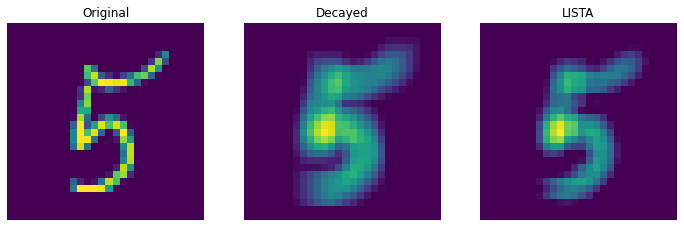

In [14]:
# examples of recovered images
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.imshow(train_high[0][0])
plt.title('Original')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(train_low[0][0])
plt.title('Decayed')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(train_lista[0][0])
plt.title('LISTA')
plt.axis('off')
plt.show()

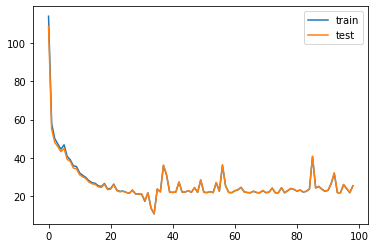

In [15]:
plt.plot(range(len(train_loss)), train_loss, label='train')
plt.plot(range(len(test_loss)), test_loss, label='test')
plt.legend()
plt.show()

In [16]:
print('Train Errors')
print(tc.mean((train_ista - train_lista)**2).item())
print('Test Errors')
print(tc.mean((test_ista - test_lista)**2).item())

Train Errors
21.974146642830696
Test Errors
22.00963607309461


In [31]:
image = train_high[:4].to(device)
low= train_low[:4].to(device)
ista = train_ista[:4].to(device)
print(image.shape)
mse_loss = nn.MSELoss()
# mse_loss(lista(im).squeeze(0).squeeze(0), image)
print(mse_loss(image, low))
print(mse_loss(ista, low))

torch.Size([4, 1, 28, 28])
tensor(1929.1513, device='cuda:0', dtype=torch.float64)
tensor(149.1253, device='cuda:0', dtype=torch.float64)


In [311]:
tc.save(lista.state_dict(), 'lista.pth')

### おまけ

3番目の画像で差のあるピクセル数
低解像度画像 - 元の画像 737
ISTAで復元した画像 - 元の画像 180


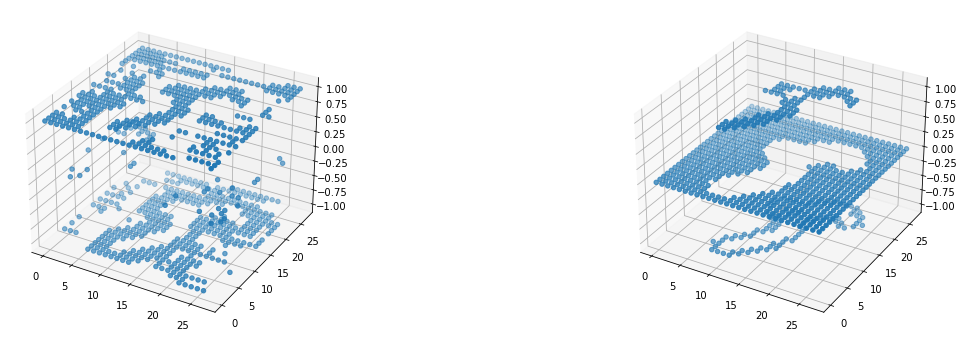

z = 1が元の画像にはあるが、低解像画像には存在しないピクセル
z = -1がその逆


In [241]:
from mpl_toolkits.mplot3d import Axes3D
i = 3
high = train_high[i][0]
low = train_low[i][0]
ista_rec = train_ista[i][0]

fig = plt.figure(figsize=(20, 6))
xmesh, ymesh = np.meshgrid(np.arange(high.shape[0]), np.arange(high.shape[1]))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(xmesh, ymesh, np.sign(high-low))
print(f'{i}番目の画像で差のあるピクセル数')
print('低解像度画像 - 元の画像', tc.sum(abs(high - low)>0).item())

ax = fig.add_subplot(122, projection='3d')
ax.scatter(xmesh, ymesh, np.sign(high-ista_rec))
print('ISTAで復元した画像 - 元の画像', tc.sum(abs(high-ista_rec)>0).item())
plt.show()
print('z = 1が元の画像にはあるが、低解像画像には存在しないピクセル')
print('z = -1がその逆')

In [242]:
result_square = {'low': 0, 'ista': 0}
for i in range(train_high.shape[1]):
    train_img = train_high[i][0]
    low_img = train_low[i][0]
    ista_img = train_ista[i][0]
    
    low_loss = tc.sum((train_img - low_img)**2).item()
    result_square['low'] += low_loss
    
    ista_loss = tc.sum((train_img - ista_img)**2).item()
    result_square['ista'] += ista_loss
print(result_square)
print(result_square['low'] - result_square['ista'])

{'low': 1114561.5381234721, 'ista': 684300.6274609817}
430260.9106624904
